Least Squares Example
===

From solution of N.S. equations on domain $(x,z)\in[-0.5,0.5]^2$

$$ \dfrac{\partial \textbf{u}}{\partial t} + (\textbf{u}\cdot{\bf\nabla})\textbf{u} = -\nabla p + \dfrac{1}{R_N}\nabla^2 {\textbf u} + \sin(\omega t)T\hat{e}_x+T\hat{e}_z,$$
$$ \dfrac{\partial T}{\partial t} + \textbf{u}\cdot{\bf\nabla}T = \dfrac{1}{Pr\,R_N}\nabla^2 T,$$
$$ \nabla\cdot\textbf{u}=0,$$

with no-slip boundary conditions for the velocity (0 on all walls), no-flux boundary conditions for temperature on sidewalls, Dirichlet boundary conditions for temperature on endwalls (0.5 top wall, -0.5 bottom wall).

First order linear theory provides eigenmode solutions for the vorticity on domain $(X,Z)\in[0,\pi]^2$: 

$$\eta_{m:n}=A_\eta \sin(mX)\sin(nZ)\sin(\sigma t),$$ 

where $\sigma^2=m^2/(m^2+n^2)$. Note that $<\eta_{m:n},\eta_{k:\ell}>=c_{m:n}\delta_{mk}\delta_{n\ell}$ forms an orthogonal basis.

Then we quantify (after removing viscous boundary layers) the scalar projection coefficient $C_{m:n}$ by projecting the Direct Numerical Simuation (DNS) vorticity's amplitude $A(\eta)$ onto the space of $\eta_{m:n}$:

$$C_{m:n} = \dfrac{\langle A(\eta),\eta_{m:n}\rangle}{\|\eta_{m:n}\|^2},$$

where 

$$A(\eta) = \max_{t\in[0,\tau)}|\eta|.$$

In [15]:
from hellaPy import *
from plt_style import *
import cheb
import qp
from numpy import *
from pylab import *


In [2]:
def qLS(field,cutoff_mode=100):
    M,N = [ k-1 for k in field.shape ]
    Dx,x= cheb.cheb(M)
    Dz,z= cheb.cheb(N)
    wx  = cheb.clenshaw_curtis_quad(M)
    wz  = cheb.clenshaw_curtis_quad(N)
    x,z,wx,wz = x/2,z/2,wx/2,wz/2
    bl  = qp.get_blayer_thickness(field)
    mx  = max(bl['mhalfx'],bl['mhalfz'])
    clip= abs(x-(x[0]-mx)).argmin()
    print(clip,mx)
    X,Z = meshgrid((x+0.5)*pi,(z+0.5)*pi,indexing='ij')
    C   = zeros((cutoff_mode,cutoff_mode))
    for m in range(1,cutoff_mode):
        for n in range(1,cutoff_mode):
            C[m,n] = LS(field,X,Z,wx,wz,m,n,clip=clip)
    return C

def Th(X,Z,m,n):
    return sin(m*X)*sin(n*Z)

def LS(field,X,Z,wx,wz,m,n,clip=40):
    f = field[clip:-clip,clip:-clip]
    q = Th(X,Z,m,n)[clip:-clip,clip:-clip]
    Wx= wx[clip:-clip]
    Wz= wz[clip:-clip]
    qn= Wx@(f*q)@Wz
    qd= Wx@(q*q)@Wz
    return qn/qd

In [3]:
mkl_set_num_threads(12)
# Structure of Dict:
#   Rn : (Rn,frequency,eta_amplitude)
Q = load('m1n1_eta_amplitude.pykl',allow_pickle=True).item()

MKL THREADS SET: 2


In [4]:
Q

{'1e3': ('1e3',
  '691e-3',
  array([[3.97353669e-19, 1.53699148e-10, 1.16022643e-09, ...,
          1.16102964e-09, 1.54229739e-10, 5.97805826e-19],
         [1.53623415e-10, 1.39923140e-10, 4.79659534e-10, ...,
          4.80079316e-10, 1.39946974e-10, 1.54163459e-10],
         [1.16008600e-09, 4.79696903e-10, 1.90767020e-09, ...,
          1.90775105e-09, 4.80215930e-10, 1.16110807e-09],
         ...,
         [1.16058150e-09, 4.79907292e-10, 1.90772869e-09, ...,
          1.90764651e-09, 4.79395886e-10, 1.15952993e-09],
         [1.53751640e-10, 1.39998054e-10, 4.79787336e-10, ...,
          4.79332136e-10, 1.39957884e-10, 1.53237025e-10],
         [4.15078396e-18, 1.53656857e-10, 1.16040931e-09, ...,
          1.15958879e-09, 1.53115962e-10, 1.53045154e-18]])),
 '1e4': ('1e4',
  '704e-3',
  array([[9.03688230e-19, 3.92429022e-09, 1.73319777e-08, ...,
          1.73289485e-08, 3.92227509e-09, 2.05771128e-18],
         [3.92395597e-09, 2.94163323e-09, 3.12848431e-08, ...,
          

In [5]:
C = { Rn : qLS(Q[Rn][-1]) for Rn in Q.keys() }

36 0.11979701719998453
37 0.12624583656870159
23 0.05012585797388924
14 0.01877238177317636
15 0.011023611886356144


In [6]:
D = { Rn : diag(C[Rn])[1::2] for Rn in C.keys() }

In [7]:
Rn_labels = { Rn : '$10^{'+Rn.split('e')[-1]+'}$' for Rn in D.keys() }

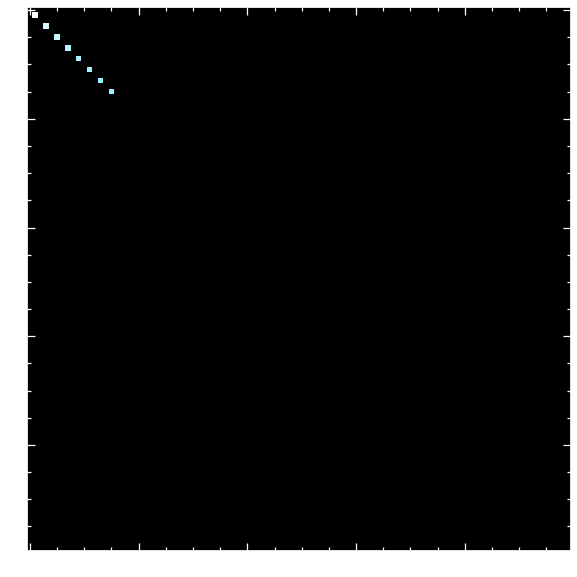

In [18]:
figure(1,figsize=(10,10))
imshow(log10(around(abs(C['1e7']),5)+1e-16),cmap=myKWh)


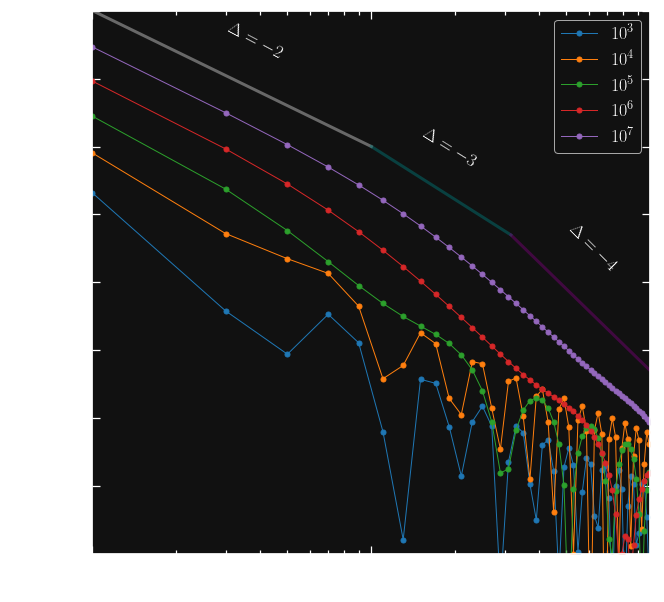

In [19]:
figure(2,figsize=(10,10))
for Rn in D.keys():
  c = D[Rn]
  loglog(arange(len(c))*2+1,abs(c),'o-',label=Rn_labels[Rn])
legend()
xlabel(r'$m$',color='w')
ylabel(r'$\dfrac{\langle A(\eta),\eta_{m:m}\rangle}{\|\eta_{m:m}\|^2}$',color='w')
s = sqrt(10)
loglog(r_[   1,  10],r_[1e-2,1e-4],'-',lw=3,c='#cccccc77')
loglog(r_[  10,s*10],r_[1e-4,5e-6],'-',lw=3,c='#00777777')
loglog(r_[s*10, 100],r_[5e-6,5e-8],'-',lw=3,c='#77007777')
annotate(r'$\Delta=-2$',xy=( 3,2.0e-3),fontsize=18,rotation=-28)
annotate(r'$\Delta=-3$',xy=(15,5.0e-5),fontsize=18,rotation=-32)
annotate(r'$\Delta=-4$',xy=(50,1.5e-6),fontsize=18,rotation=-45)
yticks(10.**arange(-10,-1))
xlim(1,100)
_=ylim(1e-10,1e-2)